# notebook for computing time resolution vs Nphe of calibration pulses using real filter wheel scan data

for questions ask Julian Sitarek (jsitarek (at) uni.lodz.pl) 

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

from ctapipe_io_lst import LSTEventSource, LSTR0Corrections
from ctapipe.io import EventSource

from ctapipe.calib.camera import CameraCalibrator
from lstchain.io import (
#    DL1ParametersContainer,
    standard_config,
)
from traitlets.config import Config

plt.rcParams['font.size'] = 25

In [2]:
# prepare the calibration, and specify some settings and input data
charge_config = Config({
    
})

calib_file = "data20201123/calibration.Run3016.0000.hdf5"
calib_time_file = "data20201123/time_calibration.Run3016.0000.hdf5"
drs4file="data20201123/drs4_pedestal.Run3015.0000.fits"
data_dir='data20201123/'

source_config = {
            "EventSource": {
                "allowed_tels": standard_config["allowed_tels"],
                "max_events": standard_config["max_events"],
            },
            "LSTEventSource": {
                "allowed_tels": [1],
                "calibrate_flatfields_and_pedestals": True,
                "LSTR0Corrections":{
                    "drs4_pedestal_path": drs4file,
                    "calibration_path": calib_file,
                    "drs4_time_calibration_path": calib_time_file,
                    "r1_sample_start": 3,
                    "r1_sample_end":39,
                    "calib_scale_high_gain": 1.,   # default is 1.18
                },
            },   
            "LocalPeakWindowSum":{
                "window_shift":4,
                "window_width":8,
                "apply_integration_correction": False,
            },            
}

geom = CameraGeometry.from_name('LSTCam-002')

# loop over those runs
runs=[3017, 3022, 3032, 3037, 3043, 3048, 3054]
skipevents=150 # skip first events
numevents=5000 # number of events to be processed per run (not counting the skipped ones)

minnphe = 5   # time resolution curve will be computed in range minnphe - maxnphe
maxnphe = 70
mineventfit = 50 # for the fits we need at least mineventfit events per charge bin per pixel

# estimate where to look for the pulses (to lower the bias from the pedestal fluctuations)

mean time in range: 13.634995971206681  to  22.239940897812463
using slices:  9  to  34


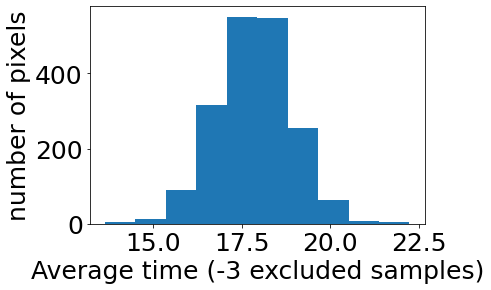

In [3]:
#data_path = data_dir+f'LST-1.1.Run0{runs[0]}.0000.fits.fz'
#source_config['EventSource']['max_events']=1000
#reader = EventSource(input_url=data_path, config=Config(source_config))

##allowed_tels=[1],
#r1_dl1_calibrator_test = CameraCalibrator(  image_extractor_type="LocalPeakWindowSum",
#                                            config=Config(source_config),
#                                            subarray=reader.subarray)
#minv = np.min(r1_dl1_calibrator_test.time_corrector.fan_array[0,:,0]/2)
#maxv = np.max(r1_dl1_calibrator_test.time_corrector.fan_array[0,:,0]/2)
#plt.hist(r1_dl1_calibrator_test.time_corrector.fan_array[0,:,0]/2)

#r0corr = LSTR0Corrections (config=Config(source_config)["LSTEventSource"],
#                           subarray=reader.subarray)
#fan,fbn =r0corr.load_drs4_time_calibration_file(source_config["LSTEventSource"]["LSTR0Corrections"]['drs4_time_calibration_path'])
fan,fbn =LSTR0Corrections.load_drs4_time_calibration_file(source_config["LSTEventSource"]["LSTR0Corrections"]['drs4_time_calibration_path'])
#r0corr.load_drs4_time_calibration_file(source_config["LSTEventSource"]["LSTR0Corrections"]['drs4_time_calibration_path'])
minv = np.min(fan[0,:,0]/2)
maxv = np.max(fan[0,:,0]/2)
plt.hist(fan[0,:,0]/2)

plt.xlabel('Average time (-3 excluded samples)')
plt.ylabel('number of pixels')

margin = 4+4 # +-4 slices of integration window and +-4 slices 
offset = 3 # first 3 slices are removed
print('mean time in range:',minv,' to ', maxv)
firstslice = int(minv - margin + offset + 0.5)
lastslice = int(maxv + margin + offset+0.5)+1
firstslice = max (firstslice, 3)
lastslice = min (lastslice, 39)
print("using slices: ",firstslice, " to ", lastslice)
source_config ["LSTEventSource"]["LSTR0Corrections"]["r1_sample_start"]=firstslice
source_config ["LSTEventSource"]["LSTR0Corrections"]["r1_sample_end"]=lastslice

# fill the signal tables 
new method starts here: instead of directly computing RMS of arrival time we will make fits for each pixel and charge bin, first get all the data into an 2D array of lists

In [4]:
bins=np.arange(minnphe,maxnphe)
nbins=bins.shape[0]+1
npix=1855

allcharges = np.empty((npix,nbins), dtype=object)
alltimes = np.empty((npix,nbins), dtype=object)
for i in range(npix):
    for j in range(nbins):
        allcharges[i,j]=[]
        alltimes[i,j]=[]

source_config ["EventSource"]["max_events"]=5000        
for run in runs:
    print(f"processing run {run}")
    data_path = data_dir+f'LST-1.1.Run0{run}.0000.fits.fz'
    reader = EventSource(input_url=data_path, config=Config(source_config))

    r1_dl1_calibrator = CameraCalibrator(  image_extractor_type="LocalPeakWindowSum",
                                            config=Config(source_config),
                                            subarray=reader.subarray)
    
    # this switches off the DRS4 time calibration (for tests)
    #r1_dl1_calibrator.time_corrector=None
    
    # FIXME: if there are some bad pixels we should exclude them
    meanchs = []
    for i, ev in enumerate(reader):
        #r0_r1_calibrator.calibrate(ev)
        
        if i%100 == 1:
            print(f"event {i}")
        #print(ev.lst.tel[1].evt.tib_masked_trigger)
        if i<skipevents:
            continue
        
        r1_dl1_calibrator(ev)
        
        charges=ev.dl1.tel[1].image
        times=ev.dl1.tel[1].peak_time
        evtmean=np.mean(charges)
        evtstd=np.std(charges)
        
        avrtime = np.mean(times[charges>5])
        times-=avrtime
        
        # a few hardcoded cuts to deal with the lack of proper trigger tags
        if evtmean<4:  # exclude pedestal events and small showers
            continue
        if evtstd>evtmean:  # exclude (big) showers
            continue
        if np.sum(charges>5)<300:
            continue  # not enought events to get average event time
            
        meanchs.append(evtmean)
        ibins=np.digitize(charges, bins)                    
        for ipix in range(npix):
            ibin=ibins[ipix]
            allcharges[ipix,ibin].append(charges[ipix])
            alltimes[ipix,ibin].append(times[ipix])
             
        #print(np.std(times), evtmean,evtstd, charges[0:10])
    print("<Nphe>=",np.mean(meanchs), " from ",len(meanchs), " events")
    #bad_pix = np.where(ev.r1_dl1_calibrator.mon_data.tel[1].calibration.dc_to_pe[0]<0)[0]
    #print("bad pixels: ", bad_pix)


processing run 3017


Using first event as time reference for counters, this will lead to wrong timestamps / trigger types for all but the first subrun
Using first event as time reference for dragon. UCTS timestamp: 1606185816116083575 dragon_counter: 3116083300
Using first event as time reference for TIB. UCTS timestamp: 1606185816116083575 tib_counter: 3116084000
No drive report specified, pointing info will not be filled


event 1
event 101
event 201
event 301
event 401
event 501
event 601
event 701
event 801
event 901
event 1001
event 1101
event 1201
event 1301
event 1401
event 1501
event 1601
event 1701
event 1801
event 1901
event 2001
event 2101
event 2201
event 2301
event 2401
event 2501
event 2601
event 2701
event 2801
event 2901
event 3001
event 3101
event 3201
event 3301
event 3401
event 3501
event 3601
event 3701
event 3801
event 3901
event 4001
event 4101
event 4201
event 4301
event 4401
event 4501
event 4601
event 4701
event 4801
event 4901
<Nphe>= 22.871746  from  1854  events
processing run 3022


Using first event as time reference for counters, this will lead to wrong timestamps / trigger types for all but the first subrun
Using first event as time reference for dragon. UCTS timestamp: 1606186530408835303 dragon_counter: 10408835000
Using first event as time reference for TIB. UCTS timestamp: 1606186530408835303 tib_counter: 10408835300
No drive report specified, pointing info will not be filled


event 1
event 101
event 201
event 301
event 401
event 501
event 601
event 701
event 801
event 901
event 1001
event 1101
event 1201
event 1301
event 1401
event 1501
event 1601
event 1701
event 1801
event 1901
event 2001
event 2101
event 2201
event 2301
event 2401
event 2501
event 2601
event 2701
event 2801
event 2901
event 3001
event 3101
event 3201
event 3301
event 3401
event 3501
event 3601
event 3701
event 3801
event 3901
event 4001
event 4101
event 4201
event 4301
event 4401
event 4501
event 4601
event 4701
event 4801
event 4901
<Nphe>= 35.121925  from  1880  events
processing run 3032


Using first event as time reference for counters, this will lead to wrong timestamps / trigger types for all but the first subrun
Using first event as time reference for dragon. UCTS timestamp: 1606187323918232933 dragon_counter: 5918232700
Using first event as time reference for TIB. UCTS timestamp: 1606187323918232933 tib_counter: -1000000100
No drive report specified, pointing info will not be filled


event 1
event 101
event 201
event 301
event 401
event 501
event 601
event 701
event 801
event 901
event 1001
event 1101
event 1201
event 1301
event 1401
event 1501
event 1601
event 1701
event 1801
event 1901
event 2001
event 2101
event 2201
event 2301
event 2401
event 2501
event 2601
event 2701
event 2801
event 2901
event 3001
event 3101
event 3201
event 3301
event 3401
event 3501
event 3601
event 3701
event 3801
event 3901
event 4001
event 4101
event 4201
event 4301
event 4401
event 4501
event 4601
event 4701
event 4801
event 4901
<Nphe>= 64.889  from  1877  events
processing run 3037


Using first event as time reference for counters, this will lead to wrong timestamps / trigger types for all but the first subrun
Using first event as time reference for dragon. UCTS timestamp: 1606187753233289743 dragon_counter: 5233289500
Using first event as time reference for TIB. UCTS timestamp: 1606187753233289743 tib_counter: -1000000100
No drive report specified, pointing info will not be filled


event 1
event 101
event 201
event 301
event 401
event 501
event 601
event 701
event 801
event 901
event 1001
event 1101
event 1201
event 1301
event 1401
event 1501
event 1601
event 1701
event 1801
event 1901
event 2001
event 2101
event 2201
event 2301
event 2401
event 2501
event 2601
event 2701
event 2801
event 2901
event 3001
event 3101
event 3201
event 3301
event 3401
event 3501
event 3601
event 3701
event 3801
event 3901
event 4001
event 4101
event 4201
event 4301
event 4401
event 4501
event 4601
event 4701
event 4801
event 4901
<Nphe>= 30.19096  from  1894  events
processing run 3043


Using first event as time reference for counters, this will lead to wrong timestamps / trigger types for all but the first subrun
Using first event as time reference for dragon. UCTS timestamp: 1606188262037209703 dragon_counter: 2037209400
Using first event as time reference for TIB. UCTS timestamp: 1606188262037209703 tib_counter: -1000000100
No drive report specified, pointing info will not be filled


event 1
event 101
event 201
event 301
event 401
event 501
event 601
event 701
event 801
event 901
event 1001
event 1101
event 1201
event 1301
event 1401
event 1501
event 1601
event 1701
event 1801
event 1901
event 2001
event 2101
event 2201
event 2301
event 2401
event 2501
event 2601
event 2701
event 2801
event 2901
event 3001
event 3101
event 3201
event 3301
event 3401
event 3501
event 3601
event 3701
event 3801
event 3901
event 4001
event 4101
event 4201
event 4301
event 4401
event 4501
event 4601
event 4701
event 4801
event 4901
<Nphe>= 15.793904  from  1873  events
processing run 3048


Using first event as time reference for counters, this will lead to wrong timestamps / trigger types for all but the first subrun
Using first event as time reference for dragon. UCTS timestamp: 1606188704911288503 dragon_counter: 2911288200
Using first event as time reference for TIB. UCTS timestamp: 1606188704911288503 tib_counter: -1000000100
No drive report specified, pointing info will not be filled


event 1
event 101
event 201
event 301
event 401
event 501
event 601
event 701
event 801
event 901
event 1001
event 1101
event 1201
event 1301
event 1401
event 1501
event 1601
event 1701
event 1801
event 1901
event 2001
event 2101
event 2201
event 2301
event 2401
event 2501
event 2601
event 2701
event 2801
event 2901
event 3001
event 3101
event 3201
event 3301
event 3401
event 3501
event 3601
event 3701
event 3801
event 3901
event 4001
event 4101
event 4201
event 4301
event 4401
event 4501
event 4601
event 4701
event 4801
event 4901
<Nphe>= 34.336464  from  1876  events
processing run 3054


Using first event as time reference for counters, this will lead to wrong timestamps / trigger types for all but the first subrun
Using first event as time reference for dragon. UCTS timestamp: 1606189284420999703 dragon_counter: 5420999400
Using first event as time reference for TIB. UCTS timestamp: 1606189284420999703 tib_counter: -1000000100
No drive report specified, pointing info will not be filled


event 1
event 101
event 201
event 301
event 401
event 501
event 601
event 701
event 801
event 901
event 1001
event 1101
event 1201
event 1301
event 1401
event 1501
event 1601
event 1701
event 1801
event 1901
event 2001
event 2101
event 2201
event 2301
event 2401
event 2501
event 2601
event 2701
event 2801
event 2901
event 3001
event 3101
event 3201
event 3301
event 3401
event 3501
event 3601
event 3701
event 3801
event 3901
event 4001
event 4101
event 4201
event 4301
event 4401
event 4501
event 4601
event 4701
event 4801
event 4901
<Nphe>= 10.301322  from  1905  events


# example of fits for a single pixel

mean Nphe =  5.533299 , num entries =  109
[ 0.05046935 -0.13870248  0.78552072 17.51912637]


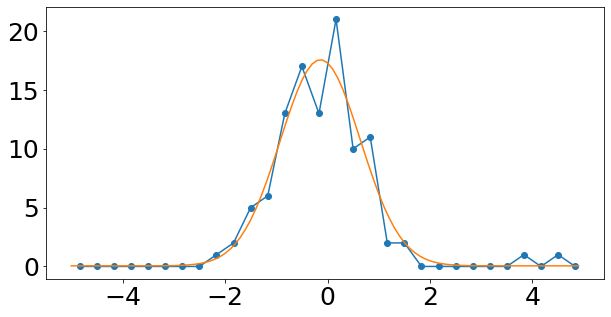

mean Nphe =  6.537067 , num entries =  159
[ 0.43533677 -0.18653545  0.60113898 32.06283199]


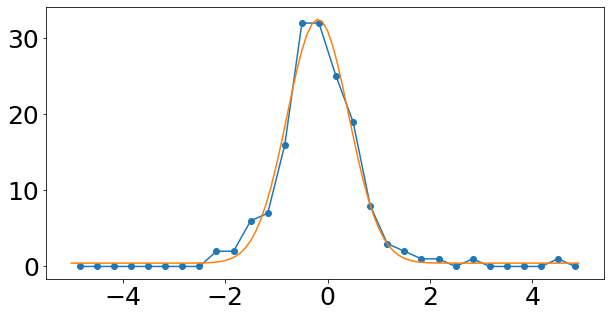

mean Nphe =  7.546673 , num entries =  216
[ 0.48325463 -0.21889677  0.62036526 42.97944846]


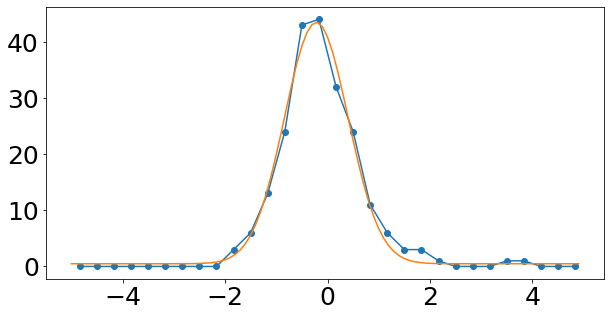

mean Nphe =  8.515627 , num entries =  243
[ 0.20152693 -0.23346653  0.65235601 48.30238235]


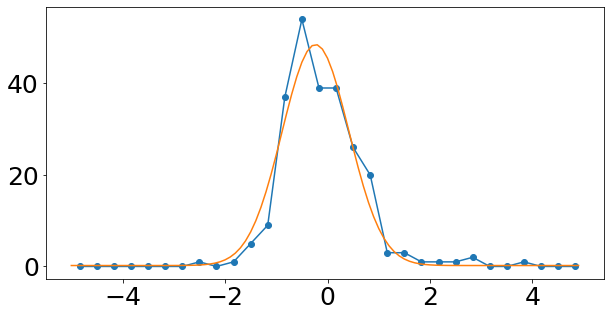

mean Nphe =  9.49178 , num entries =  279
[ 0.62849922 -0.20301684  0.57981703 59.66413781]


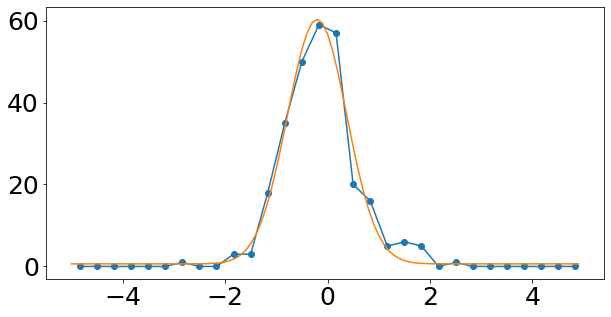

mean Nphe =  10.514126 , num entries =  315
[ 0.60635642 -0.12711945  0.53271163 74.09248514]


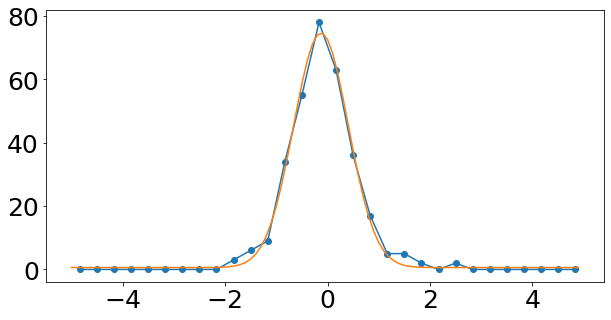

mean Nphe =  11.518883 , num entries =  303
[ 0.32665124 -0.15236289  0.57541694 67.75959914]


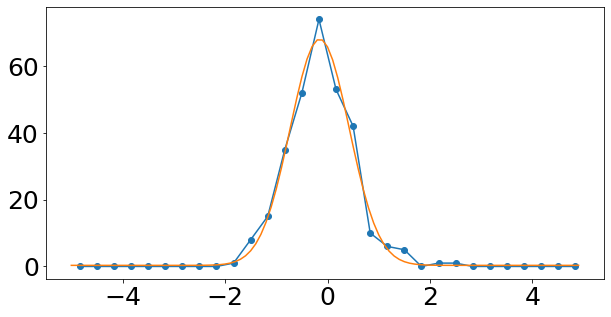

mean Nphe =  12.498681 , num entries =  317
[ 0.2201221  -0.21222383  0.55245057 74.71571453]


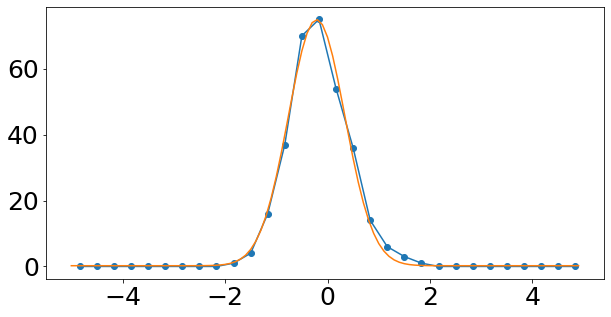

mean Nphe =  13.4797735 , num entries =  354
[ 0.39388423 -0.1951013   0.52075943 87.37973242]


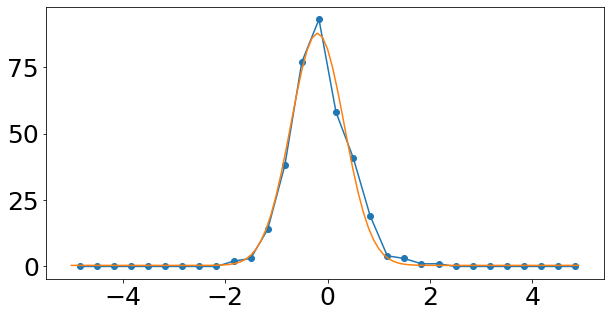

mean Nphe =  14.496859 , num entries =  304
[ 0.41037945 -0.16166427  0.55325168 70.11089949]


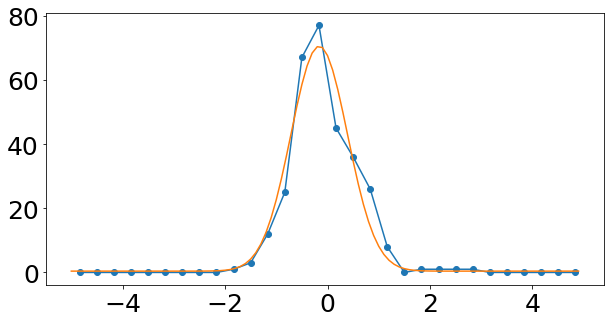

mean Nphe =  15.5105505 , num entries =  280
[ 0.33092793 -0.12819147  0.54443449 65.96643331]


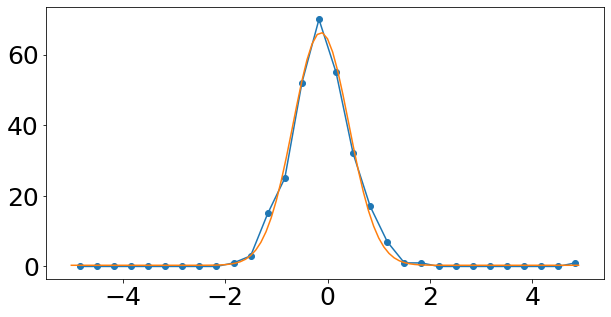

mean Nphe =  16.4815 , num entries =  296
[-0.13551468 -0.12392275  0.57775533 69.06544891]


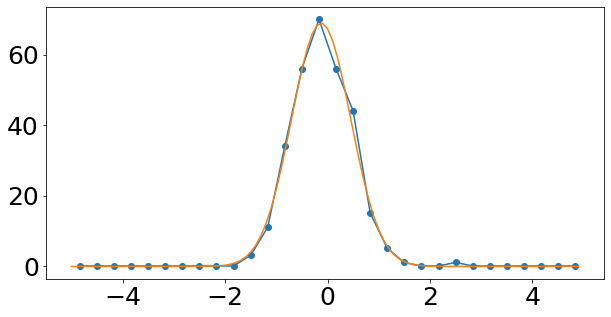

mean Nphe =  17.514666 , num entries =  300
[ 2.78553560e-02 -9.24563817e-02  5.02468567e-01  7.91753093e+01]


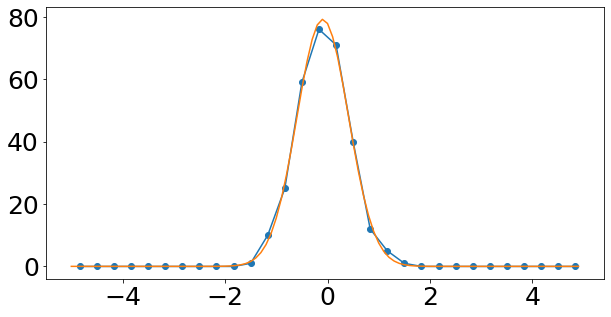

mean Nphe =  18.502739 , num entries =  283
[ 0.23028693 -0.15031202  0.49334849 74.41969506]


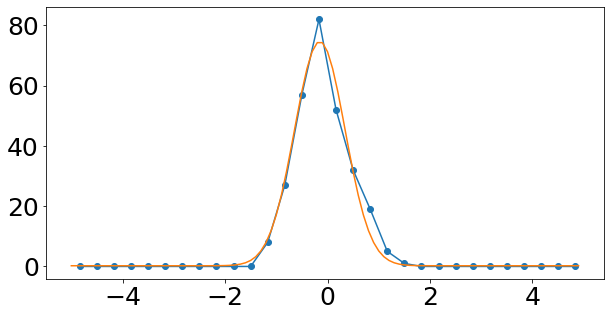

mean Nphe =  19.502743 , num entries =  289
[ 3.18055569e-03 -1.66990384e-01  5.18917560e-01  7.40366464e+01]


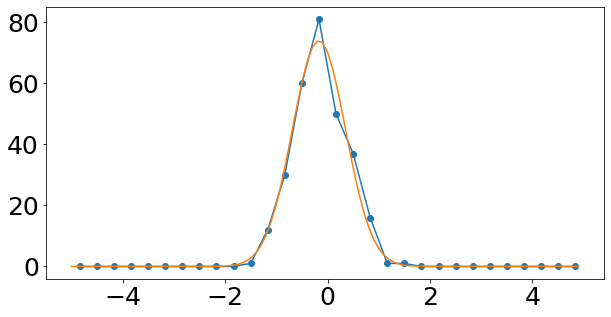

mean Nphe =  20.504416 , num entries =  270
[-0.18345013 -0.11569711  0.53375107 68.63998617]


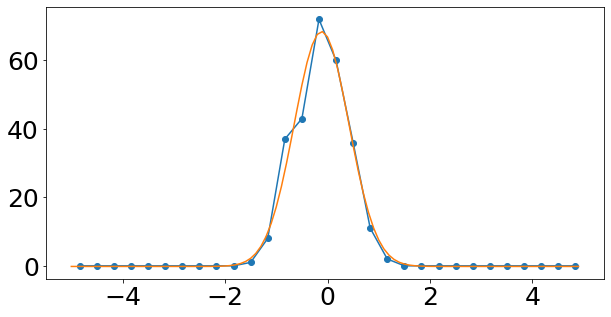

mean Nphe =  21.511463 , num entries =  270
[-0.07982258 -0.09712028  0.48049863 75.38680124]


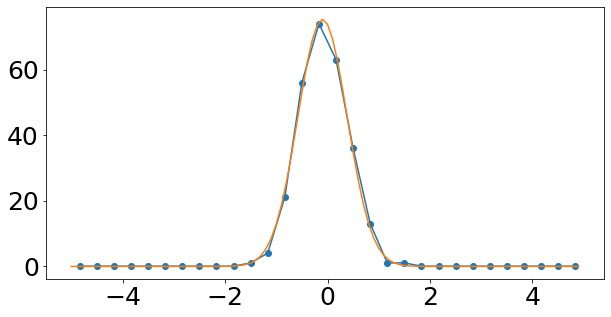

mean Nphe =  22.512918 , num entries =  290
[ 0.38143181 -0.17154155  0.46261497 80.07248242]


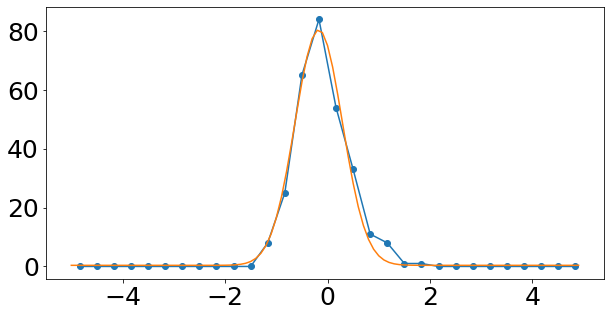

mean Nphe =  23.51068 , num entries =  294
[-2.53101213e-02 -1.06019478e-01  4.97569917e-01  7.87775383e+01]


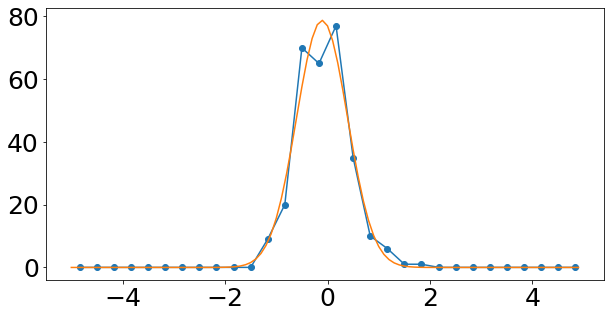

mean Nphe =  24.496986 , num entries =  312
[ 0.29454895 -0.15053537  0.4179192  96.46582001]


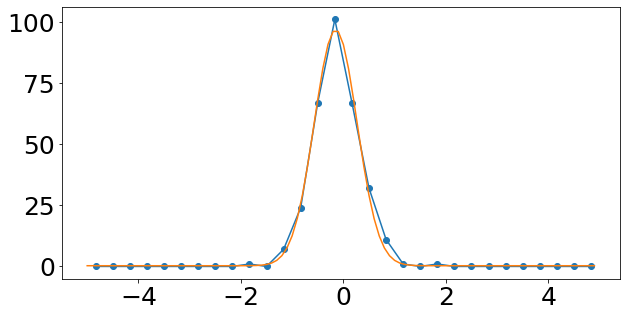

mean Nphe =  25.515383 , num entries =  299
[-0.08976807 -0.14848235  0.4774231  84.03312334]


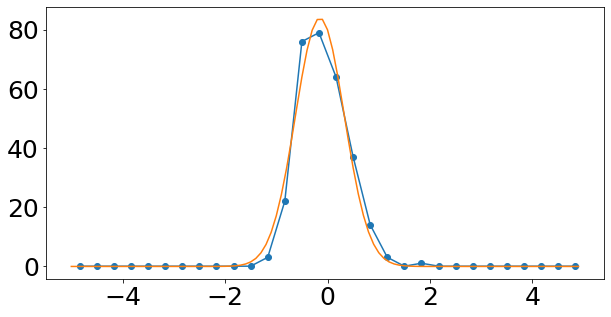

mean Nphe =  26.488134 , num entries =  337
[ 2.36319821e-01 -6.99940515e-02  4.44961965e-01  9.85966032e+01]


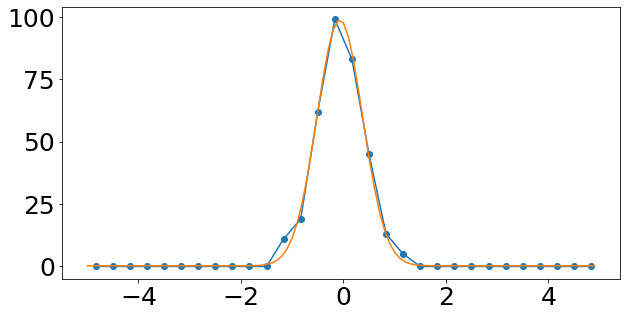

mean Nphe =  27.53317 , num entries =  370
[ 3.46660094e-03 -1.43069717e-01  4.47896887e-01  1.09822124e+02]


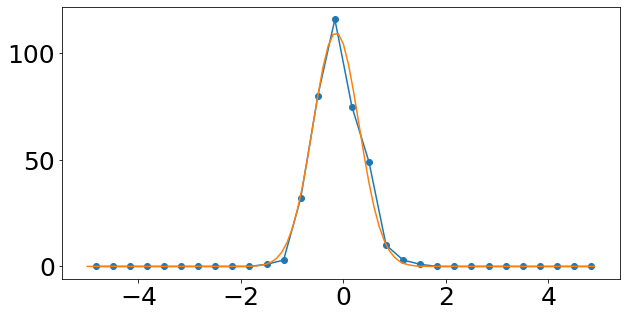

mean Nphe =  28.510637 , num entries =  361
[-1.73093596e-01 -9.03505708e-02  4.71141750e-01  1.03358702e+02]


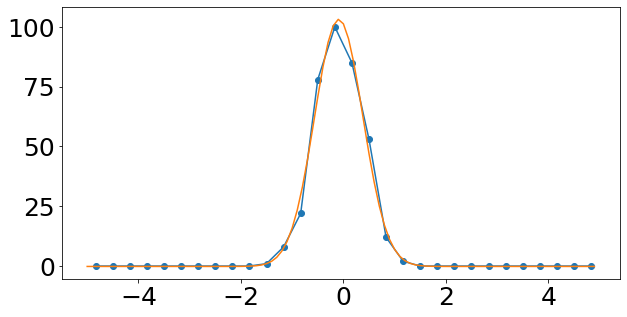

mean Nphe =  29.500393 , num entries =  393
[ 4.94887794e-01 -8.36308476e-02  4.15259458e-01  1.21098082e+02]


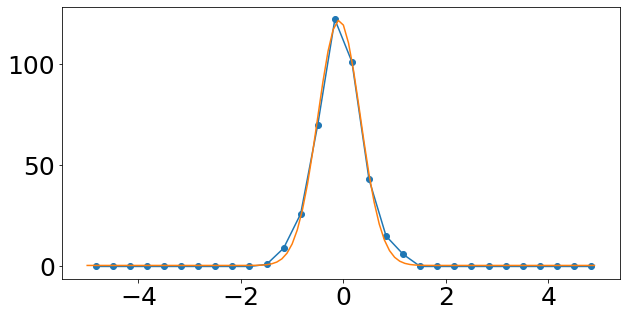

mean Nphe =  30.513134 , num entries =  363
[ -0.18374167  -0.15557163   0.46740065 104.84589618]


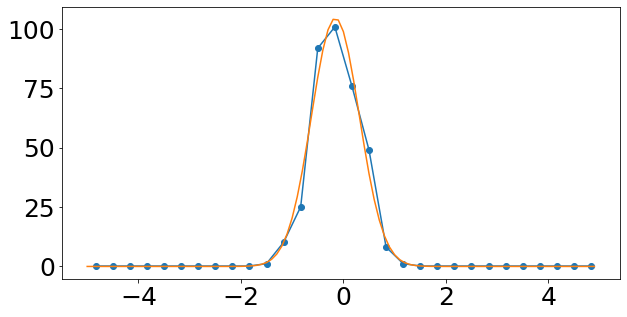

mean Nphe =  31.48954 , num entries =  387
[-2.35553538e-01 -1.09702198e-01  4.33492228e-01  1.20886317e+02]


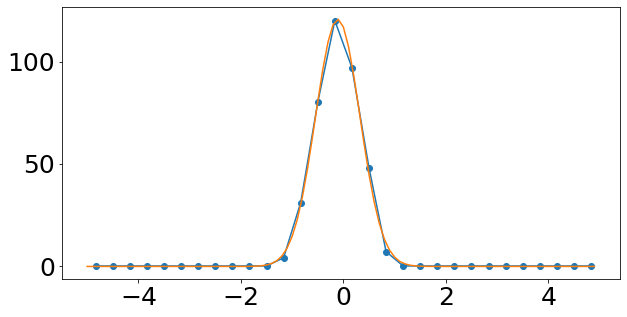

mean Nphe =  32.49364 , num entries =  413
[-1.23163887e-01 -4.33008899e-02  4.63188667e-01  1.19632497e+02]


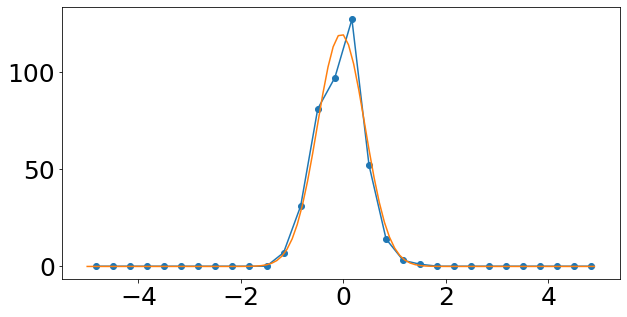

mean Nphe =  33.490402 , num entries =  370
[-2.83857464e-01 -7.74768948e-02  4.78099918e-01  1.05281984e+02]


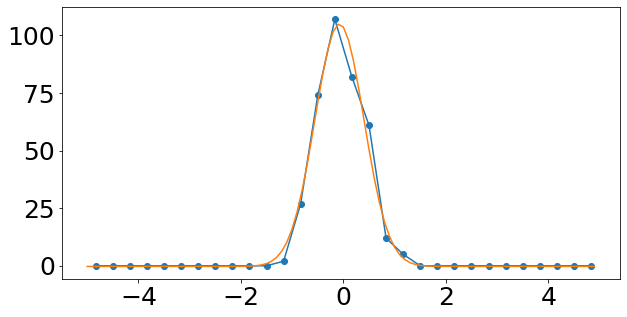

mean Nphe =  34.492672 , num entries =  339
[ -0.26744078  -0.13133473   0.45742139 100.8859988 ]


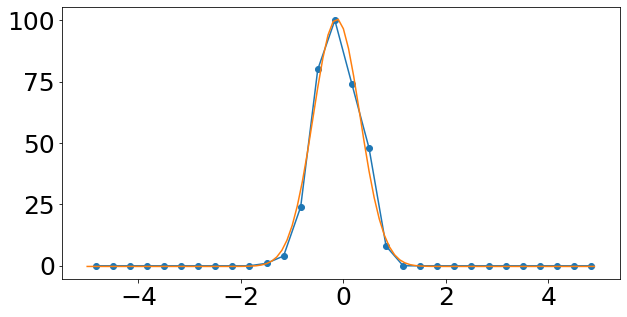

mean Nphe =  35.482346 , num entries =  313
[-1.77242736e-01 -3.53283639e-02  4.64081932e-01  9.12125046e+01]


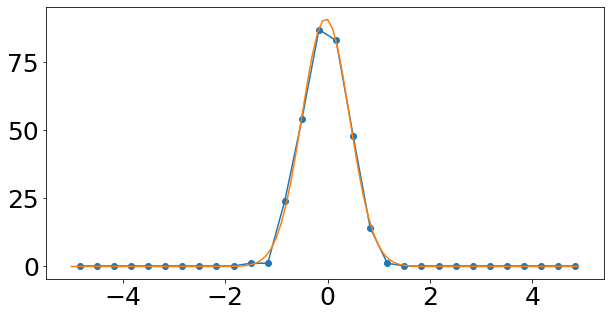

mean Nphe =  36.49433 , num entries =  270
[ 2.17548016e-01 -6.31539483e-02  3.97141621e-01  8.82227196e+01]


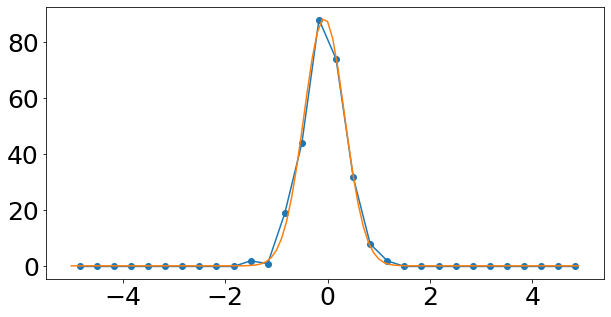

mean Nphe =  37.503628 , num entries =  259
[-0.13692124 -0.10514271  0.42937478 81.48651474]


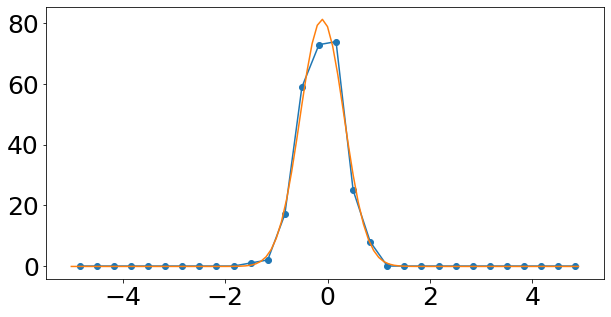

mean Nphe =  38.480267 , num entries =  233
[ 1.78553088e-01 -2.37161254e-02  4.01088320e-01  7.54751328e+01]


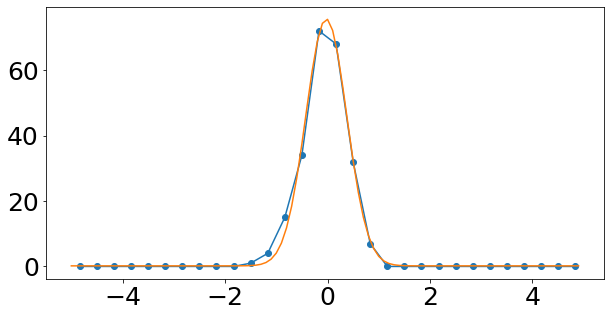

mean Nphe =  39.50134 , num entries =  189
[-0.12527994 -0.07683085  0.45474849 56.3677709 ]


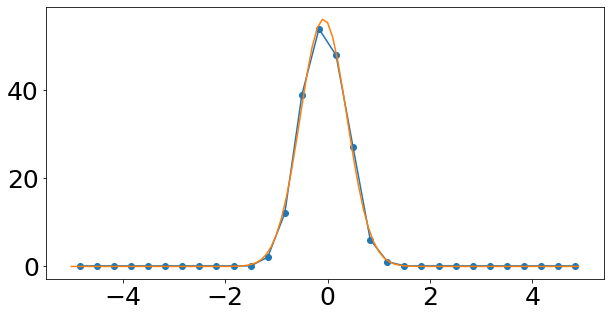

mean Nphe =  40.506626 , num entries =  167
[-0.11443593 -0.11056476  0.47956495 47.2601654 ]


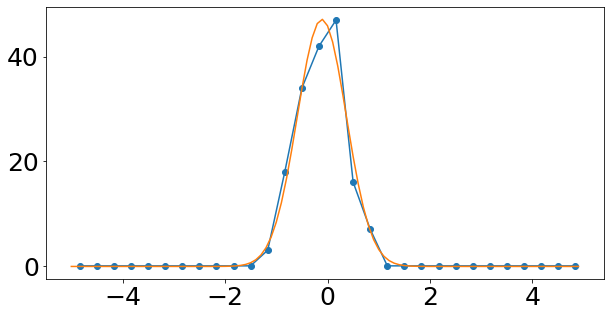

mean Nphe =  41.492737 , num entries =  138
[-0.16535487 -0.10087449  0.49113053 38.70868155]


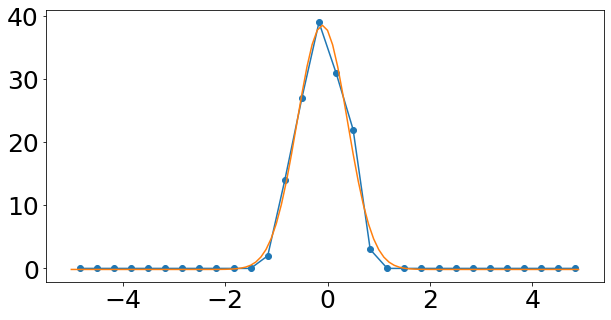

mean Nphe =  42.47818 , num entries =  106
[ 0.24737414 -0.10469486  0.3422289  38.30500979]


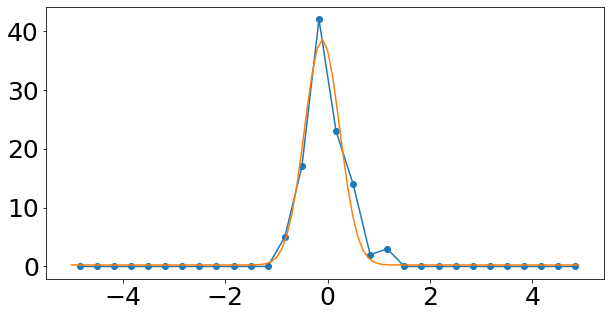

mean Nphe =  43.462677 , num entries =  85
[-0.14186325 -0.12855017  0.51754977 22.93367325]


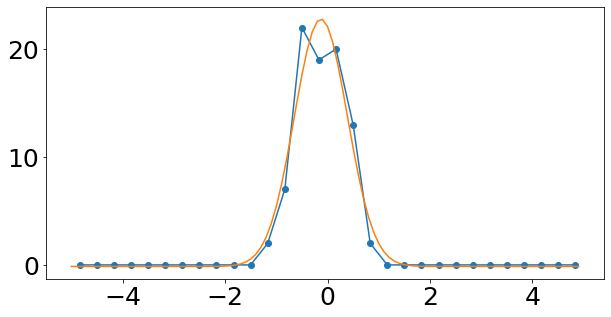

mean Nphe =  44.50989 , num entries =  71
[ 0.10250804 -0.10811941  0.34271996 26.35588071]


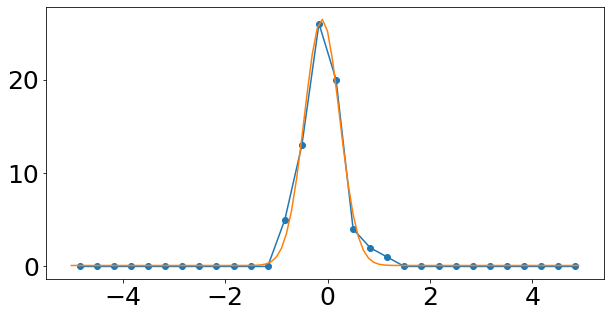

mean Nphe =  45.48721 , num entries =  73
[-1.04680982e-02 -9.04556243e-02  4.29285085e-01  2.27106892e+01]


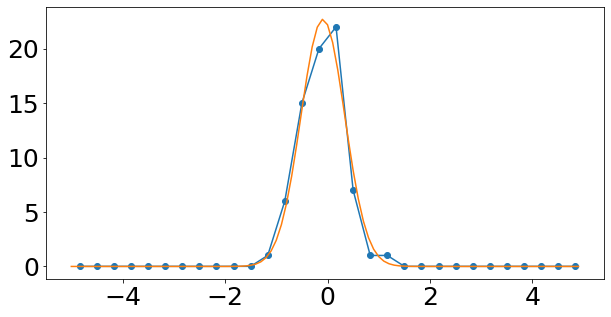

mean Nphe =  46.368423 , num entries =  52
[-0.09249763 -0.04694016  0.45705705 15.93676743]


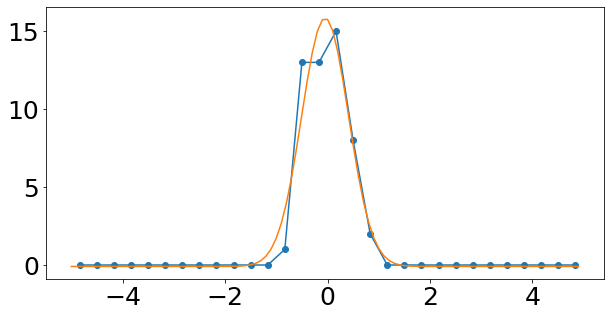

mean Nphe =  53.530796 , num entries =  51
[-0.06801515  0.03121411  0.45281556 15.57667379]


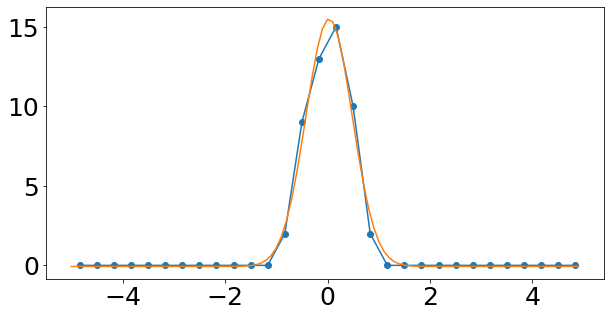

mean Nphe =  54.55134 , num entries =  63
[-9.62581280e-03 -3.80951773e-02  3.78717802e-01  2.22228536e+01]


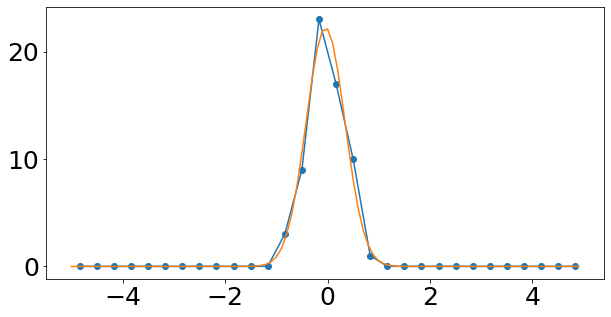

mean Nphe =  55.51657 , num entries =  59
[ 0.02884693 -0.26870627  0.42302781 18.2748809 ]


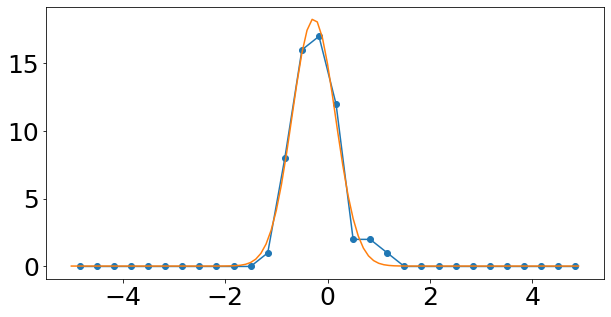

mean Nphe =  56.53386 , num entries =  75
[ 0.11206184 -0.07764291  0.32620327 29.20416837]


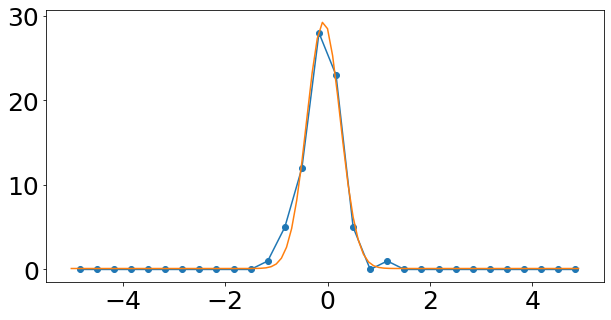

mean Nphe =  57.511204 , num entries =  76
[-8.52060970e-02 -1.37005514e-02  4.40603329e-01  2.37094462e+01]


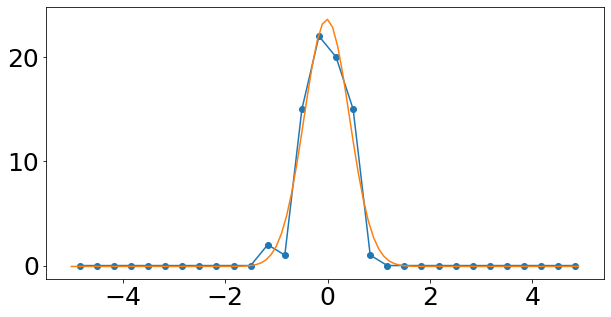

mean Nphe =  58.523285 , num entries =  74
[ 0.03935382 -0.13252467  0.37632394 25.73202507]


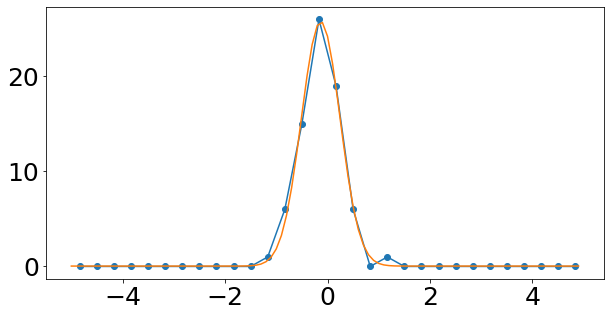

mean Nphe =  59.501186 , num entries =  89
[-0.06304498 -0.13459804  0.41689908 28.99215002]


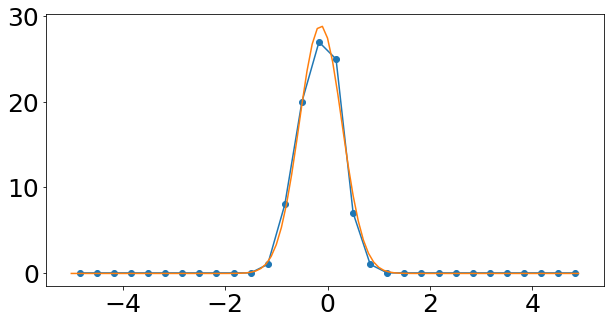

mean Nphe =  60.45735 , num entries =  82
[ 0.17585811 -0.13233066  0.327502   31.15355263]


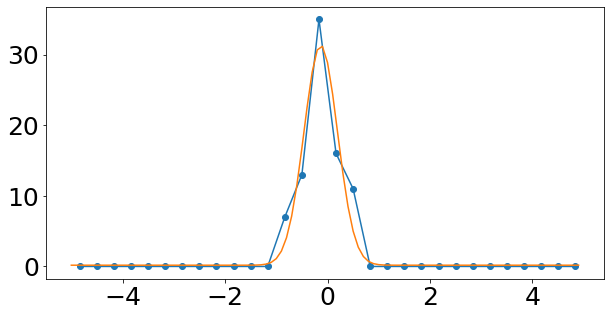

mean Nphe =  61.507477 , num entries =  66
[-1.50632696e-02 -1.15643116e-01  4.31306477e-01  2.04885034e+01]


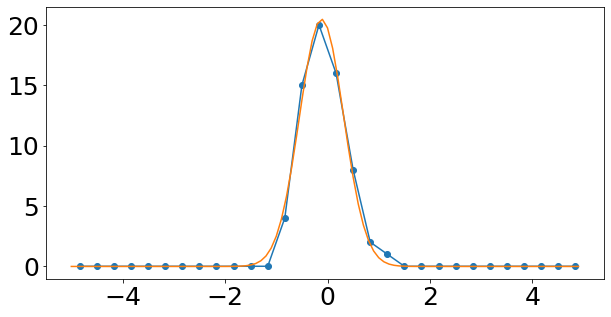

mean Nphe =  62.494793 , num entries =  86
[-0.09358679 -0.08736162  0.43871525 26.91883355]


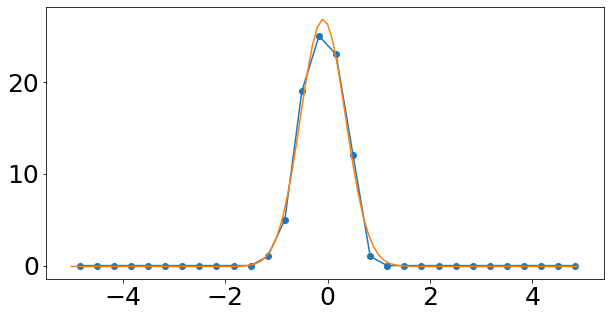

mean Nphe =  63.530556 , num entries =  87
[-0.08702826 -0.12745249  0.39829381 29.91891582]


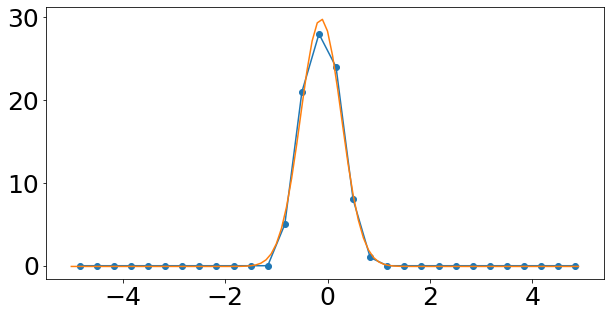

mean Nphe =  64.49681 , num entries =  81
[-5.89637463e-03 -1.03149256e-01  3.97316836e-01  2.71696846e+01]


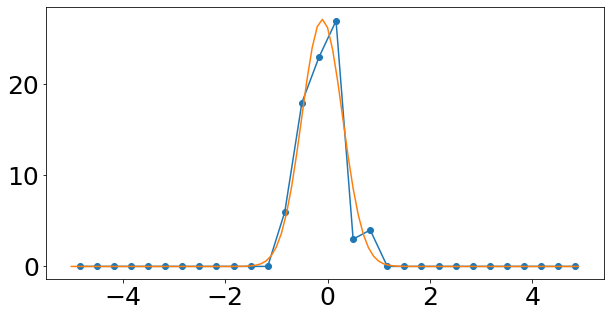

mean Nphe =  65.54577 , num entries =  75
[-0.17095852 -0.04365161  0.4813726  22.13583215]


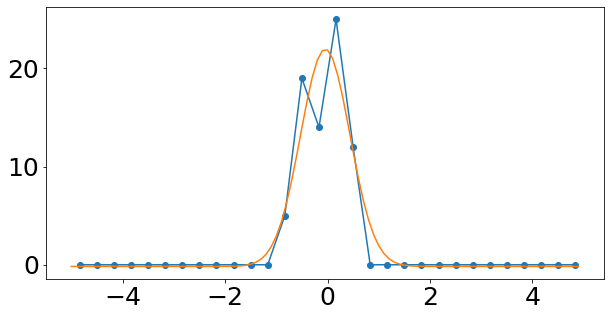

mean Nphe =  66.44434 , num entries =  86
[-0.05028209 -0.13231561  0.46656018 24.94199617]


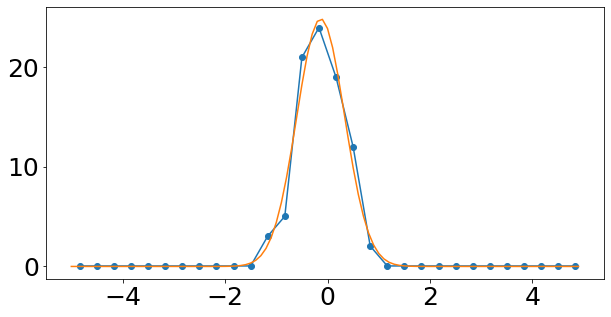

mean Nphe =  67.4542 , num entries =  64
[-0.1078422  -0.07440484  0.44864606 19.9288438 ]


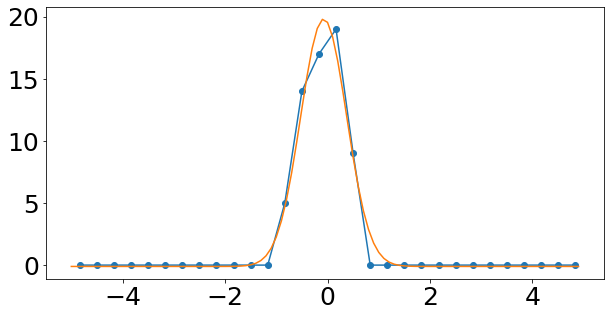

mean Nphe =  68.493515 , num entries =  91
[-0.06075858 -0.10473375  0.42735479 28.88382587]


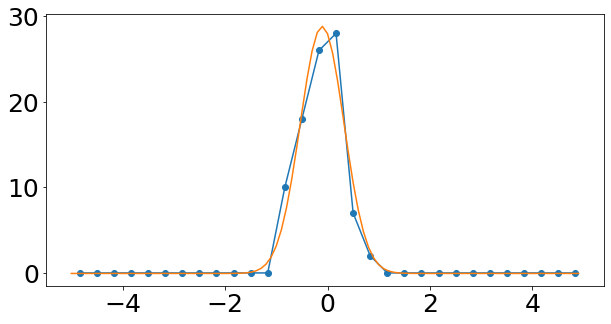

mean Nphe =  74.60452 , num entries =  531
[ 1.76204548e-01 -9.29471394e-02  3.95699573e-01  1.76674012e+02]


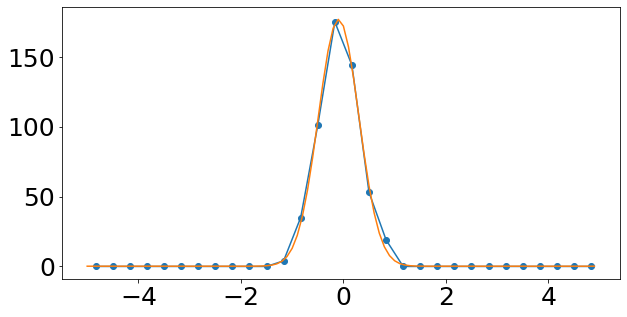

[0.37425144 1.40710473 0.88080765]


Text(0, 0.5, 'Time resolution [ns]')

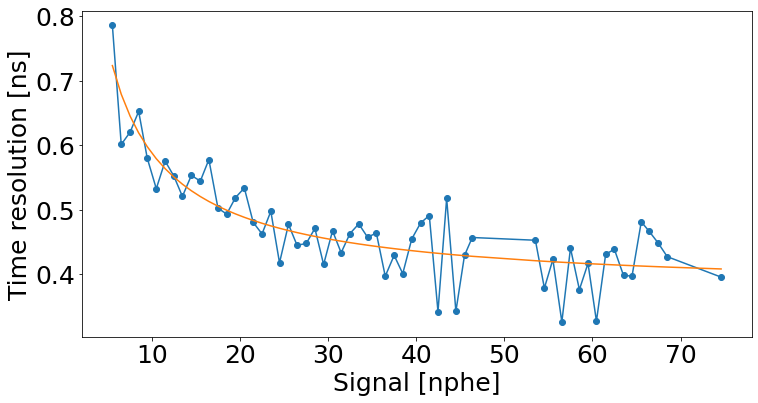

In [5]:
def fgauss (x, bgd, mean, sigma, norm):
    return bgd+ norm*np.exp(-(x-mean)**2/(2*sigma**2))


pixid=55

timeresy=[]
timeresx=[]
for binnr in range (1, nbins):
    numentries=len(alltimes[pixid,binnr])
    if numentries<mineventfit:
        continue
    meancharge=np.mean(allcharges[pixid,binnr])
    hist = np.histogram(alltimes[pixid,binnr], bins=30, range=(-5, 5))
    xs=hist[1][:-1]+0.5*(hist[1][1]-hist[1][0])
    ys=hist[0]
    print ("mean Nphe = ",meancharge, ", num entries = ", numentries)


    meanp=np.mean(alltimes[pixid,binnr])
    sigmap=np.std(alltimes[pixid,binnr])
    norm0=max(ys)
    p0 = [0.1, meanp, sigmap, norm0]

    plt.figure(figsize=(10, 5))
    plt.plot(xs, ys, marker='o')

    pars, cov = curve_fit(f=fgauss, xdata=xs, ydata=ys, p0=p0)
    print(pars)
    xs2=np.arange(-5, 5, 0.1)
    yfit = fgauss(xs2, *pars)
    plt.plot(xs2, yfit)
    plt.show()
    
    timeresx.append(meancharge)
    timeresy.append(np.abs(pars[2]))

plt.figure(figsize=(12, 6))
plt.plot(timeresx, timeresy, marker='o')

def func (x, t0, t1, t2):
    return np.sqrt(t0**2 + t1**2/x + (t2/x)**2)

p0=[1,1,1]
pars, cov = curve_fit(f=func, xdata=timeresx, ydata=timeresy, p0=p0, bounds=(0, 20))
print(pars)
yfit = func(timeresx, *pars)

plt.plot(timeresx, yfit)
plt.xlabel("Signal [nphe]")
plt.ylabel("Time resolution [ns]")

# now fits for all the pixels, first we fit for each pixel each charge bin separately, from those results of the fit we construct the arrival time resolution vs Nphe for each pixel, and those curves we fit with a model curve to estimate the value at 5 phe

0 [0.37003055 1.42732462 0.81045438] 0.7554119214245942
1 [3.71218501e-01 1.41620653e+00 3.77171300e-09] 0.7341194472436944
2 [0.37202003 1.42057191 0.64074208] 0.7472789531093896
3 [4.21191274e-01 1.15793951e+00 2.07992258e-06] 0.6675079572353669
4 [3.88189430e-01 1.20213993e+00 1.78932923e-08] 0.6631131985418316
5 [0.36588193 1.41259659 1.26664927] 0.7727427953240215
6 [4.37236917e-01 7.91085461e-01 3.65553140e-13] 0.562440541352728
7 [3.61611352e-01 1.44414530e+00 2.82093869e-08] 0.7401850427264128
8 [3.74151044e-01 1.43422141e+00 1.47675214e-08] 0.7425545206044282
9 [3.95335414e-01 1.35047121e+00 1.12377888e-09] 0.7218341844298851


/home/jsitarek/anaconda3/envs/lst-dev/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


10 [3.69145265e-01 1.54825950e+00 2.17418806e-10] 0.7846589848405388
11 [3.70364253e-01 1.58174924e+00 1.56417219e-08] 0.7984709210214025
12 [3.74320369e-01 1.49607495e+00 1.87637533e-11] 0.7666575454934226
13 [3.76840871e-01 1.42374243e+00 8.69326064e-10] 0.7398767073097562
14 [0.37762552 1.256153   2.54441916] 0.8468458310138689
15 [4.05062603e-01 1.23040042e+00 1.69788488e-08] 0.6832662382929311
16 [3.91967727e-01 1.35257864e+00 1.75061129e-05] 0.720786023540672
17 [3.73403936e-01 1.40500149e+00 1.15012218e-09] 0.7309147253065409
18 [3.81494101e-01 1.45885791e+00 7.16469984e-10] 0.7557718096474709
19 [3.78868021e-01 1.45350602e+00 2.96130914e-07] 0.7523808381128678
20 [0.40068524 1.00108436 2.76963253] 0.8172008399634982
21 [3.57912938e-01 1.54976840e+00 2.01361756e-11] 0.780037234504721
22 [0.37092072 1.46243252 2.55523533] 0.9091166368814817
23 [3.86457066e-01 1.26403371e+00 4.28960536e-11] 0.6847666089483398
24 [0.3905957  1.33056317 0.77065566] 0.7282863977688045
25 [0.40207038 

134 [3.11994907e-01 1.53977090e-11 1.13848496e+01] 2.298245598110876
135 [3.72939461e-01 1.53792163e+00 1.64374993e-10] 0.7823838137947895
136 [3.74057581e-01 1.41259962e+00 2.47209597e-09] 0.7341706966920651
137 [3.85510448e-01 1.37215679e+00 1.13334164e-07] 0.7246938365048005
138 [3.54546960e-01 1.58935620e+00 9.58660591e-11] 0.794301060072094
139 [3.82327090e-01 1.32173485e+00 3.46888106e-12] 0.703967760564132
140 [3.95379062e-01 1.37978334e+00 2.70162731e-07] 0.7328608427905209
141 [0.36444945 1.49767856 1.94707039] 0.8561979552612482
142 [3.52282152e-01 1.75289964e+00 2.77994687e-10] 0.859438270520134
143 [3.81137717e-01 1.54245893e+00 3.06725375e-06] 0.7881001639053186
144 [3.78969660e-01 1.39587589e+00 4.26130992e-12] 0.7302820727123518
145 [3.81410524e-01 1.41366433e+00 5.57311281e-10] 0.7383517812575828
146 [3.87146033e-01 1.43804214e+00 8.61874658e-09] 0.7506497775853329
147 [3.85996566e-01 1.35945838e+00 2.55796482e-09] 0.7201519038159926
148 [3.66366617e-01 1.58157007e+00 1

258 [4.04014710e-01 1.31083033e+00 8.83713778e-08] 0.7119572418361038
259 [3.80414577e-01 1.41262264e+00 1.57182869e-08] 0.7374386705142428
260 [3.70467224e-01 1.35609249e+00 7.74483209e-10] 0.7106640090375353
261 [3.71523758e-01 1.38222530e+00 2.15424861e-08] 0.7212068084966932
262 [3.88276716e-01 1.36030541e+00 8.24236916e-08] 0.7216958998016115
263 [3.91953780e-01 1.57452559e+00 1.13717204e-11] 0.8058870480124499
264 [3.69311298e-01 1.47816162e+00 1.39052094e-09] 0.7572207014407127
265 [3.63698540e-01 1.62792037e+00 2.80031912e-11] 0.8138191297019193
266 [3.72114476e-01 1.44009385e+00 1.59448600e-08] 0.7438032277822086
267 [4.52862141e-01 1.91210096e-08 3.29874090e-11] 0.45286214110559847
268 [3.67368770e-01 1.46044592e+00 5.57562985e-07] 0.7493599084133857
269 [0.38200511 1.26719167 1.53657039] 0.7493495825101819
270 [3.85562662e-01 1.37425886e+00 8.33038411e-12] 0.7255177810703474
271 [3.59983530e-01 1.60460898e+00 3.03533077e-10] 0.8028338160993429
272 [3.55955312e-01 1.57096746e

384 [0.38162729 1.40887504 1.99593471] 0.8378397116076208
385 [3.67301921e-01 1.47553239e+00 2.31484172e-11] 0.7552151146091282
386 [0.40520163 1.24021915 2.42670046] 0.8410541431374132
387 [3.82582774e-01 1.38077161e+00 5.06923500e-11] 0.7264128494211118
388 [3.80843783e-01 1.48234456e+00 2.48337685e-05] 0.7645332338031575
389 [0.397738   1.21652421 1.922132  ] 0.7758642978346029
390 [3.57972263e-01 1.64908613e+00 6.25496039e-07] 0.8197811632048061
391 [3.80439031e-01 1.38503052e+00 3.81514051e-10] 0.7269083589972395
392 [3.66311956e-01 1.45624820e+00 3.46449011e-10] 0.7472056011849436
393 [0.36305025 1.5024609  0.73980033] 0.7779302121521701
394 [3.86981913e-01 1.46200726e+00 2.97276236e-09] 0.7597684177780414
395 [4.64881599e-01 7.36244237e-09 8.57425108e-12] 0.46488159920438205
396 [3.72145945e-01 1.42790660e+00 1.72680013e-10] 0.7391048999402922
397 [3.50115349e-01 1.60714005e+00 1.88422688e-10] 0.7994751925322202
398 [3.57539332e-01 1.53143707e+00 9.53151163e-10] 0.77258933250388

510 [0.34763903 1.56302261 1.03644622] 0.8077311811028438
511 [3.83427367e-01 1.50743968e+00 3.90940568e-08] 0.7755587829718981
512 [0.37203152 1.31017067 2.28292044] 0.8307742904651554
513 [3.78040974e-01 1.50329309e+00 4.09052225e-09] 0.7712930691872181
514 [3.73705436e-01 1.48472466e+00 3.85289688e-08] 0.7619299274938168
515 [3.86795254e-01 1.45485333e+00 1.59801225e-08] 0.7569215367568117
516 [3.66320797e-01 1.57696824e+00 7.81126623e-09] 0.7947054131515299
517 [3.56787987e-01 1.51585657e+00 7.81922310e-08] 0.7660691184907862
518 [3.77481279e-01 1.46604157e+00 2.46397639e-08] 0.7565366419659825
519 [3.50876112e-01 1.58283666e+00 2.78307905e-10] 0.7900559619481629
520 [3.61097938e-01 1.59131984e+00 2.89039901e-06] 0.7980297514640216
521 [3.57434737e-01 1.52052752e+00 4.25807412e-11] 0.7682189640724529
522 [3.95957213e-01 1.31829175e+00 6.75363014e-08] 0.7101835963881055
523 [4.55029647e-01 2.56745603e-09 8.04931685e-12] 0.4550296465294288
524 [3.73123170e-01 1.47909820e+00 2.1779725

634 [3.76615582e-01 1.41424519e+00 2.52314439e-10] 0.7361094954916843
635 [0.38234601 1.47813248 0.85989471] 0.7827773339176507
636 [3.76930949e-01 1.54315524e+00 8.08565913e-08] 0.7863476088314837
637 [0.38603629 1.14472842 2.87966665] 0.861860689028846
638 [3.72706383e-01 1.49262576e+00 3.34358169e-11] 0.7645236277001294
639 [3.55416364e-01 1.61676467e+00 1.80523713e-06] 0.8056713917943986
640 [3.66024332e-01 1.45839447e+00 2.19409795e-11] 0.747901531364478
641 [3.90781867e-01 1.50299220e+00 1.03706307e-06] 0.7775008552121482
642 [3.61278313e-01 1.52888547e+00 8.91937609e-09] 0.7733176409421594
643 [3.65458680e-01 1.46251587e+00 2.42245467e-07] 0.7492333271429312
644 [3.51057923e-01 1.60125701e+00 1.19527809e-08] 0.7975252161888444
645 [3.79131182e-01 1.42947184e+00 4.47284198e-10] 0.7432485444437942
646 [3.90975019e-01 1.43355858e+00 2.61005248e-09] 0.7509191074692566
647 [0.38256785 1.28422433 1.80832591] 0.7791060863822747
648 [0.36584626 1.55701538 0.49069127] 0.7926752054229896


759 [3.70123933e-01 1.51354735e+00 2.35385389e-10] 0.771464090869058
760 [4.43666646e-01 1.04001330e-10 2.69657195e-09] 0.4436666463002356
761 [0.38210176 1.28900288 1.75693518] 0.7757449922267537
762 [3.83741244e-01 1.45168892e+00 2.42058094e-10] 0.7541468620559751
763 [0.40530212 1.09962809 1.86512321] 0.7384128760504376
764 [3.90302497e-01 1.48420695e+00 2.75403406e-08] 0.7700065542423871
765 [3.77178216e-01 1.33662032e+00 5.51022851e-07] 0.7068056186392193
766 [0.41607416 0.96019188 2.93668019] 0.8381378274180188
767 [4.01866915e-01 1.31859492e+00 5.21779778e-12] 0.7136074067815534
768 [3.78768202e-01 1.35183470e+00 1.94372511e-07] 0.7134120566120355
769 [3.53098328e-01 1.56442479e+00 5.27031108e-11] 0.7836857875235663
770 [4.04153191e-01 1.22045232e+00 2.15142843e-12] 0.6791469455721466
771 [3.71333188e-01 1.39651448e+00 4.35745022e-07] 0.7265940226692792
772 [3.95666694e-01 1.33982806e+00 3.90143539e-08] 0.7180389822871244
773 [3.53854451e-01 1.49173130e+00 8.02128501e-11] 0.7551

887 [3.67757058e-01 1.49457278e+00 9.94154473e-09] 0.7628858448367841
888 [3.73404306e-01 1.40772995e+00 6.65843437e-12] 0.7319641379439454
889 [0.35391167 1.43693713 1.95572297] 0.8313875304768507
890 [0.39440315 1.39374436 1.57266165] 0.8018660082193008
891 [3.65947769e-01 1.46933976e+00 9.67044708e-08] 0.7521367120936682
892 [0.37976652 1.19257013 3.68997944] 0.9865623367775378
893 [3.66694346e-01 1.48320227e+00 1.32840354e-10] 0.7579198742000265
894 [3.66917931e-01 1.39296612e+00 3.37098523e-08] 0.7229797309218672
895 [0.39678067 0.99062132 2.9296085 ] 0.8348684067771531
896 [3.74111902e-01 1.31870023e+00 3.84525185e-11] 0.6983937094691169
897 [4.40137169e-01 3.17575408e-08 3.32748552e-11] 0.44013716933734337
898 [3.74545391e-01 1.48666681e+00 1.15350646e-09] 0.7630988719257942
899 [0.39538358 1.29473563 1.36809001] 0.7526374014858441
900 [0.38437724 1.33426925 1.61863926] 0.7801284960612602
901 [0.38979774 1.20988002 1.9510807 ] 0.7726401787752937
902 [3.82966370e-01 1.40215770e+0

1013 [3.60454170e-01 1.58078975e+00 1.88560135e-08] 0.7935404556188774
1014 [0.35361217 1.49634312 2.06989797] 0.8626872074262552
1015 [3.64890536e-01 1.60737016e+00 3.35749293e-06] 0.8061469282139058
1016 [4.01656345e-01 1.18521741e+00 1.13580358e-07] 0.6650382561134716
1017 [3.66408042e-01 1.44519094e+00 2.54845249e-08] 0.7429469844581705
1018 [3.73987383e-01 1.42974449e+00 2.49746223e-06] 0.740743157790269
1019 [3.68152193e-01 1.54135252e+00 1.60857367e-09] 0.7814662838692645
1020 [3.86480059e-01 1.41674257e+00 8.76002676e-08] 0.7421581619871954
1021 [3.93759646e-01 1.41072982e+00 1.87757191e-10] 0.743692400487292
1022 [3.60023375e-01 1.50571457e+00 2.43397697e-09] 0.7635784848136572
1023 [3.56811998e-01 1.59021942e+00 4.36328944e-09] 0.7956597028539566
1024 [0.36662675 1.39066192 0.78738436] 0.738919654876615
1025 [3.47525230e-01 1.77545946e+00 1.23157634e-09] 0.8667323940342354
1026 [3.41275674e-01 1.54836164e+00 1.56840450e-08] 0.7719804652524913
1027 [3.79628252e-01 1.40046479e+

1136 [3.54586611e-01 1.63520290e+00 3.09577109e-07] 0.8127172738379763
1137 [3.93210379e-01 1.46155003e+00 1.40269712e-09] 0.7627844373551075
1138 [3.88915287e-01 1.33318217e+00 1.40839126e-08] 0.7118497298081017
1139 [3.82684230e-01 1.44163756e+00 3.26148765e-09] 0.7497406141459205
1140 [0.39098011 1.28738212 1.43960612] 0.7531498003706362
1141 [3.73837591e-01 1.58349460e+00 1.04820090e-11] 0.8007781045295917
1142 [0.40996456 1.0835293  2.92988625] 0.8638561357928157
1143 [3.95291398e-01 1.50253421e+00 8.71061105e-12] 0.7796006020499443
1144 [3.65899944e-01 1.54760082e+00 2.29289560e-09] 0.7828770206510194
1145 [3.65687049e-01 1.69164600e+00 5.65584398e-11] 0.8402739182967349
1146 [0.36398923 1.58519097 1.68373014] 0.8651312759118246
1147 [3.75207790e-01 1.45136436e+00 2.80085888e-07] 0.7497150028249123
1148 [4.56181583e-01 1.37798471e-10 3.61399712e-10] 0.4561815830318722
1149 [3.74783751e-01 1.48130366e+00 2.73480150e-07] 0.7611274296146379
1150 [0.39466178 1.30351935 1.44391235] 0.

1258 [0.34861268 1.51474584 2.68458459] 0.9320416150011817
1259 [3.48751412e-01 1.72794735e+00 1.16637620e-10] 0.8478136311526215
1260 [3.65510857e-01 1.46914198e+00 2.84099362e-08] 0.7518469379808711
1261 [3.62462127e-01 1.50107272e+00 7.77562033e-09] 0.7629040943583695
1262 [3.99518869e-01 1.44745132e+00 1.35897903e-10] 0.7606828466912752
1263 [3.86701563e-01 1.37501978e+00 5.62134507e-08] 0.7264117116598005
1264 [3.86950259e-01 1.32842662e+00 3.50635649e-10] 0.7089950358962276
1265 [3.79414470e-01 1.44281005e+00 1.93322461e-08] 0.7485288964705039
1266 [4.16366093e-01 1.37698229e+00 4.06520357e-11] 0.7433550739283239
1267 [3.62685323e-01 1.62187565e+00 2.99582396e-06] 0.8109480693019354
1268 [3.76908391e-01 1.45098711e+00 6.31327362e-09] 0.7504216521573566
1269 [0.38985567 1.3556941  2.42650066] 0.8689562475813776
1270 [4.58980075e-01 1.40129045e-09 1.52032180e-09] 0.4589800745298581
1271 [0.36341799 1.61953033 2.4053466 ] 0.9423778557787608
1272 [0.40623942 1.12067346 2.2136579 ] 0.

1380 [3.85446817e-01 1.49675268e+00 1.52541667e-08] 0.7724137255769559
1381 [0.36506826 1.42626761 2.46025021] 0.8844410339744916
1382 [3.65496239e-01 1.50512831e+00 1.61844904e-08] 0.7659436954086167
1383 [3.87521771e-01 1.50277822e+00 5.20579942e-07] 0.7757845032884121
1384 [3.86888509e-01 1.39196489e+00 1.31047864e-11] 0.7329365404080873
1385 [3.64824514e-01 1.49469655e+00 1.64768756e-07] 0.7615251022785908
1386 [3.76824821e-01 1.43898850e+00 1.16557609e-07] 0.7457442755989488
1387 [3.94503430e-01 1.43939788e+00 2.65881760e-09] 0.7549875551709739
1388 [3.64231934e-01 1.42805403e+00 2.24392171e-07] 0.7352091991878534
1389 [3.97018020e-01 1.35338513e+00 2.55933842e-09] 0.7238463740130342
1390 [3.8279337e-01 1.5310399e+00 8.0004224e-09] 0.7844408192271456
1391 [3.70788068e-01 1.45282941e+00 8.88815448e-12] 0.7480818470944872
1392 [3.72567633e-01 1.56351355e+00 3.82691976e-11] 0.7922888131867394
1393 [0.41041526 1.11772267 2.73609602] 0.8472014713342593
1394 [3.75314520e-01 1.59417888e+

1503 [4.00180259e-01 1.46966401e+00 1.87445498e-10] 0.7694976933050791
1504 [3.94666364e-01 1.41301226e+00 2.34134364e-08] 0.745038435735927
1505 [3.69634419e-01 1.34204559e+00 1.98156726e-10] 0.7048736585417692
1506 [3.76526548e-01 1.28742184e+00 3.32355369e-07] 0.6879413072782513
1507 [3.65026867e-01 1.48751460e+00 4.64133994e-11] 0.7588046864412412
1508 [0.40954629 1.18870508 2.80886186] 0.8751687337872394
1509 [3.37513189e-01 1.62303357e+00 6.70189051e-07] 0.8004765753662776
1510 [3.58903641e-01 1.51897030e+00 4.80865019e-08] 0.7682876941134671
1511 [3.46732121e-01 1.57942588e+00 4.21123903e-08] 0.7868547409052591
1512 [3.86007418e-01 1.29944777e+00 3.68209001e-10] 0.6976493587589654
1513 [3.81122818e-01 1.47655478e+00 7.56863762e-08] 0.7624286226500273
1514 [3.64737281e-01 1.71949862e+00 1.19091305e-07] 0.8510983413125621
1515 [3.78055124e-01 1.41834126e+00 1.12727914e-10] 0.7384199762645591
1516 [3.70124725e-01 1.56960158e+00 2.92640761e-10] 0.7935503350989478
1517 [3.78195164e-0

1626 [3.82393088e-01 1.40011014e+00 2.32926032e-08] 0.7336798726560775
1627 [3.75489123e-01 1.49544771e+00 3.85567498e-11] 0.7669842574464047
1628 [0.39704908 1.3646061  2.05739065] 0.8362967095234481
1629 [3.92741985e-01 1.38532972e+00 4.28340192e-07] 0.7335352431277188
1630 [3.81795091e-01 1.38396140e+00 1.45421210e-07] 0.7272120206736885
1631 [4.49176864e-01 6.52370630e-09 1.65187064e-13] 0.44917686353050856
1632 [3.84434515e-01 1.38434105e+00 6.16762083e-08] 0.7287454461993337
1633 [3.59753155e-01 1.45121319e+00 1.84143306e-09] 0.742041966394888
1634 [3.70862775e-01 1.50257336e+00 1.32025249e-07] 0.76751843048433
1635 [3.77214679e-01 1.43866303e+00 1.73168135e-06] 0.745815778720174
1636 [0.37528619 1.58216688 0.88097293] 0.8200821050484479
1637 [0.36183824 1.48110873 1.47086023] 0.8100621665824365
1638 [3.63199018e-01 1.44296620e+00 3.11017108e-11] 0.740502409623937
1639 [4.48558561e-01 2.63441586e-10 4.33697531e-09] 0.4485585612759575
1640 [3.50561558e-01 1.63286139e+00 1.83546694

1746 [3.87984166e-01 1.44305592e+00 1.32089881e-12] 0.7530031827372511
1747 [0.380047   1.37528416 2.74783498] 0.9081524727621904
1748 [0.39026399 1.33853534 1.37013525] 0.7653314193246324
1749 [3.89972354e-01 1.37529600e+00 1.07551791e-07] 0.7282624905790276
1750 [0.36284976 1.66639879 1.31356941] 0.869514531669661
1751 [4.04916905e-01 1.29363385e+00 1.42792601e-06] 0.7061553691924741
1752 [0.41291103 1.28823783 1.72704646] 0.7884887084414234
1753 [3.87945046e-01 1.32736041e+00 1.53622390e-08] 0.7091392588415792
1754 [3.90453020e-01 1.39333709e+00 3.55202117e-08] 0.7353442785992245
1755 [3.99777237e-01 1.33966663e+00 9.19811391e-08] 0.7202521603448717
1756 [4.02019578e-01 1.41811004e+00 5.13916660e-10] 0.7508841165137796
1757 [3.41457532e-01 1.74626694e+00 2.52627404e-11] 0.8523396585072852
1758 [3.85034257e-01 1.49323662e+00 2.64512804e-06] 0.7708453147496762
1759 [3.63780696e-01 1.56622339e+00 1.84566010e-09] 0.7892702550286648
1760 [3.63345913e-01 1.68714706e+00 3.35444698e-08] 0.8

Text(0, 0.5, 'number of pixels')

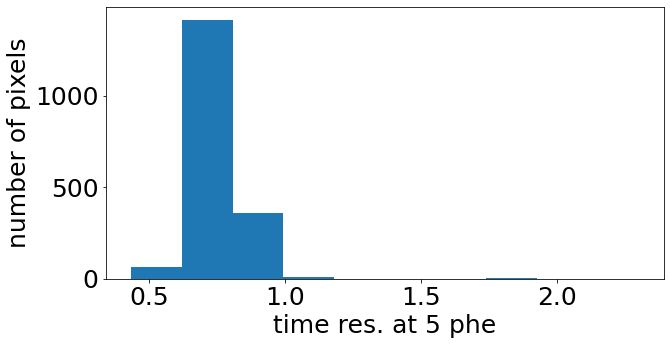

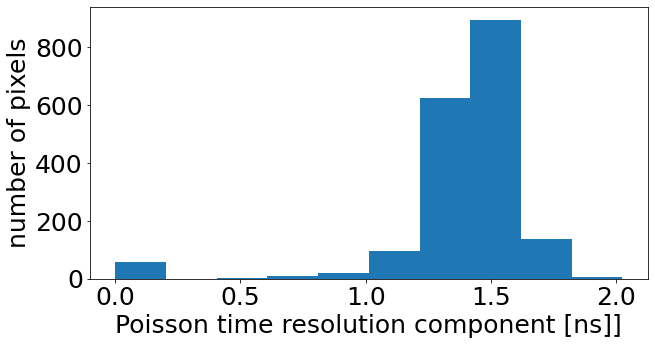

In [6]:
def fgauss (x, bgd, mean, sigma, norm):
    return bgd+ norm*np.exp(-(x-mean)**2/(2*sigma**2))

def func (x, t0, t1, t2):
    return np.sqrt(t0**2 + t1**2/x + (t2/x)**2)

val5phe=[]

poissonpar=[]

for pixid in range (npix):
    timeresy=[]
    timeresx=[]
    for binnr in range (1, nbins):
        numentries=len(alltimes[pixid,binnr])
        if numentries<mineventfit:
            continue
        meancharge=np.mean(allcharges[pixid,binnr])
        hist = np.histogram(alltimes[pixid,binnr], bins=30, range=(-5, 5))
        xs=hist[1][:-1]+0.5*(hist[1][1]-hist[1][0])
        ys=hist[0]
        #print ("mean Nphe = ",meancharge, ", num entries = ", numentries)


        meanp=np.mean(alltimes[pixid,binnr])
        sigmap=np.std(alltimes[pixid,binnr])
        norm0=max(ys)
        p0 = [0.1, meanp, sigmap, norm0]

        try:
            pars, cov = curve_fit(f=fgauss, xdata=xs, ydata=ys, p0=p0)
        except RuntimeError:
            pass
        
        timeresx.append(meancharge)
        timeresy.append(pars[2])

    # now do a fit for this pixel  
    p0=[1,1,1]
    if len(timeresy)>3:
        pars, cov = curve_fit(f=func, xdata=timeresx, ydata=timeresy, p0=p0, bounds=(0, 20))
        val5=func(5,*pars)
        print(pixid,pars, val5)
        val5phe.append(val5)
        poissonpar.append(pars[1])

plt.figure(figsize=(10, 5))

plt.hist(val5phe)
plt.xlabel('time res. at 5 phe')
plt.ylabel('number of pixels')

plt.figure(figsize=(10, 5))
plt.hist(poissonpar)
plt.xlabel('Poisson time resolution component [ns]]')
plt.ylabel('number of pixels')


## backup

data20201123/LST-1.1.Run03022.0000.fits.fz


Using first event as time reference for counters, this will lead to wrong timestamps / trigger types for all but the first subrun
Using first event as time reference for dragon. UCTS timestamp: 1606186530408835303 dragon_counter: 10408835000
Using first event as time reference for TIB. UCTS timestamp: 1606186530408835303 tib_counter: 10408835300
No drive report specified, pointing info will not be filled


[('type', '*', 8)]
6.025185 1.8295391 32
event 1
[('type', '*', 8)]
1.4537446 2.7850194 1
[('type', '*', 8)]
34.810863 6.498384 1
[('type', '*', 8)]
1.209756 1.4994705 32
[('type', '*', 8)]
35.02337 6.4701276 1
[('type', '*', 8)]
1.3012887 1.5737952 32
[('type', '*', 8)]
35.15195 6.6118493 1
[('type', '*', 8)]
1.2836851 1.6099294 32
[('type', '*', 8)]
35.00877 6.495063 1
[('type', '*', 8)]
1.3050264 1.5847653 32
[('type', '*', 8)]
35.17926 6.403038 1
[('type', '*', 8)]
1.3521574 1.5330273 32
[('type', '*', 8)]
35.13179 6.4693503 1
[('type', '*', 8)]
1.3540801 1.5737913 32
[('type', '*', 8)]
34.957188 6.5021315 1
[('type', '*', 8)]
1.428192 1.5662706 32
[('type', '*', 8)]
35.157734 6.610475 1
[('type', '*', 8)]
1.461396 1.5271546 32
[('type', '*', 8)]
1.5241572 2.4699988 1
[('type', '*', 8)]
35.260487 6.607886 1
[('type', '*', 8)]
1.3715326 1.5945152 32
[('type', '*', 8)]
35.00384 6.8852167 1
[('type', '*', 8)]
1.4541471 1.5859308 32
[('type', '*', 8)]
35.183086 6.6004977 1
[('type', '*

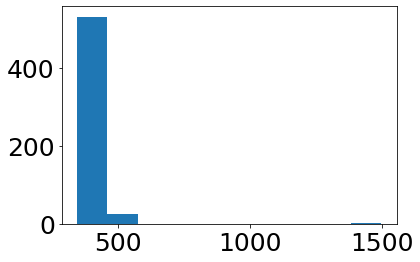

In [7]:
#reader.r0_r1_calibrator
source_config ["EventSource"]["max_events"]=30
#source_config ["LSTEventSource"]["CameraCalibrator"][""]=300
data_path = data_dir+f'LST-1.1.Run0{runs[1]}.0000.fits.fz'
print(data_path)
reader = EventSource(input_url=data_path, config=Config(source_config))

r1_dl1_calibrator = CameraCalibrator(  image_extractor_type="LocalPeakWindowSum",
                                            config=Config(source_config),
                                            subarray=reader.subarray)

lista=[]
for i, ev in enumerate(reader):
        #r0_r1_calibrator.calibrate(ev)
        
        if i%100 == 1:
            print(f"event {i}")
        #print(ev.r1.tel[1].waveform.shape)
        #print(ev.dl0.tel[1].selected_gain_channel)
        r1_dl1_calibrator(ev)
        print(r1_dl1_calibrator.image_extractor.window_width)
        charges=ev.dl1.tel[1].image
        times=ev.dl1.tel[1].peak_time
        evtmean=np.mean(charges)
        evtstd=np.std(charges)
        #print(ev.lst.tel[1]['evt']['event_id'])
        #print(ev.r1.tel[1].waveform.shape)
        print(evtmean,evtstd, ev.lst.tel[1].evt.tib_masked_trigger)
        if ev.lst.tel[1].evt.tib_masked_trigger==32:
            lista+=list(ev.r0.tel[1].waveform[0,0,:])
plt.hist(lista)
print(r1_dl1_calibrator.image_extractor)
print(ev.calibration.tel[1].dl1.relative_factor)